In [1]:
#!pip install rdkit xgboost numpy pandas scikit-learn matplotlib seaborn smogn smogn imblearn
%pip install rdkit xgboost numpy pandas scikit-learn matplot lib seaborn smogn imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, zero_one_loss, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
import smogn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')


# import os
# folder_path = '/content/drive/MyDrive/pharmahacks_2025/csv_tables'

In [4]:
%pip install gdown
import gdown
url_csv = "https://drive.google.com/drive/folders/1pFuFpNtd6oh2w6Ga7PRlt0kjjwbDjXTP?usp=sharing"
url_embeddings = "https://drive.google.com/drive/folders/1Eop8xnD8XPh5nU0omBgoQ84l7u2W_KQZ?usp=sharing"
gdown.download_folder(url_csv, quiet=True)
gdown.download_folder(url_embeddings, quiet=True)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


['c:\\Users\\misse\\Projects\\pharmahacks_25\\pharmahacks-25\\embeddings\\all_seqs.pkl',
 'c:\\Users\\misse\\Projects\\pharmahacks_25\\pharmahacks-25\\embeddings\\base_seq.pkl',
 'c:\\Users\\misse\\Projects\\pharmahacks_25\\pharmahacks-25\\embeddings\\global_embeddings_map.pkl',
 'c:\\Users\\misse\\Projects\\pharmahacks_25\\pharmahacks-25\\embeddings\\global_embeddings_max_length.npy']

In [5]:
# loading tables
# table1 = pd.read_csv(os.path.join(folder_path, 'table-1.csv'))
# table2 = pd.read_csv(os.path.join(folder_path, 'table-2.csv'))
# table3 = pd.read_csv(os.path.join(folder_path, 'table-3.csv'))

table1 = pd.read_csv('csv_tables/table-1.csv')
table2 = pd.read_csv('csv_tables/table-2.csv')
table3 = pd.read_csv('csv_tables/table-3.csv')

print(table1.head())
print(table2.head())
print(table3.head())

  Accession Number Entrez Gene Symbol                         Kinase Mutant  \
0      NP_055726.3               AAK1                           AAK1     NO   
1      NP_005148.2               ABL1     ABL1(E255K)-phosphorylated    YES   
2      NP_005148.2               ABL1  ABL1(F317I)-nonphosphorylated    YES   
3      NP_005148.2               ABL1     ABL1(F317I)-phosphorylated    YES   
4      NP_005148.2               ABL1  ABL1(F317L)-nonphosphorylated    YES   

  Kinase Group  
0        Other  
1           TK  
2           TK  
3           TK  
4           TK  
    Compound                                             SMILES  \
0   A-674563  CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...   
1    AB-1010  CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...   
2    ABT-869  CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=C2)C3=C4C(=C...   
3      AC220  CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...   
4  AG-013736  CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)C=CC4=...   

  Binding Mode (base

In [6]:

with open('embeddings/all_seqs.pkl', 'rb') as f:
  all_seqs = pickle.load(f)

with open('embeddings/base_seq.pkl', 'rb') as f:
  base_seq = pickle.load(f)

global_embeddings = np.load('embeddings/global_embeddings_max_length.npy')

with open('embeddings/global_embeddings_map.pkl', 'rb') as f:
  global_embeddings_map = pickle.load(f)

# ensure embeddings correspond to correct kinases
kinase_ids = list(global_embeddings_map.keys())
kinase_embeddings = {kinase: global_embeddings[i] for i, kinase in enumerate(kinase_ids)}

print(kinase_embeddings)

{'AAK1': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        1.0579960e-05,  5.8259507e-06,  9.1596256e-08],
      shape=(15599,), dtype=float32), 'ABL1(E255K)-phosphorylated': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.5299056e-06,  1.7210321e-05,  2.3178212e-07],
      shape=(15599,), dtype=float32), 'ABL1(F317I)-nonphosphorylated': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.2921305e-06,  1.6433652e-05,  2.4846892e-07],
      shape=(15599,), dtype=float32), 'ABL1(F317I)-phosphorylated': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.2921305e-06,  1.6433652e-05,  2.4846892e-07],
      shape=(15599,), dtype=float32), 'ABL1(F317L)-nonphosphorylated': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.4387606e-06,  1.6194173e-05,  2.3473470e-07],
      shape=(15599,), dtype=float32), 'ABL1(F317L)-phosphorylated': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
     

In [7]:
# PCA i guess??
# extract the embeddings
embeddings = np.array(list(kinase_embeddings.values()))
print(embeddings.shape)

# standardize embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# pca
pca = PCA(n_components=0.95)
embeddings_pca = pca.fit_transform(embeddings_scaled)

# convert to dataframe
embeddings_df = pd.DataFrame(embeddings_pca, index=kinase_ids)
embeddings_df_reset = embeddings_df.reset_index()
embeddings_df_reset.rename(columns={'index': 'Kinase'}, inplace=True)
print(embeddings_df_reset.head())
print(embeddings_df_reset.shape)

(442, 15599)
                          Kinase          0          1          2          3  \
0                           AAK1  -0.813679 -29.187014  13.221566  21.716599   
1     ABL1(E255K)-phosphorylated  12.826459  43.214863  13.407912  21.331444   
2  ABL1(F317I)-nonphosphorylated  13.478254  42.953426  13.528316  21.925327   
3     ABL1(F317I)-phosphorylated  13.478270  42.953411  13.528316  21.925386   
4  ABL1(F317L)-nonphosphorylated  12.943295  42.563278  13.421924  22.069048   

           4          5          6         7          8  ...       123  \
0  21.009573   0.054794 -10.262155 -8.797714  -7.910841  ... -1.554923   
1  44.701019  22.857103   8.390306 -2.437561 -23.676567  ... -0.421884   
2  44.929493  22.960983   8.603175 -2.175603 -23.007704  ... -0.432414   
3  44.929520  22.961037   8.603200 -2.175596 -23.007742  ... -0.432415   
4  45.136337  22.860001   8.589225 -2.048869 -23.198624  ... -0.317752   

        124       125       126       127       128       129

In [8]:
# # mutant
# table1['Mutant'] = table1['Mutant'].replace({'YES': 1, 'NO': 0})

# # kinase group
# kinase_group_encoder = OneHotEncoder()
# kinase_group_encoded = kinase_group_encoder.fit_transform(table1[['Kinase Group']]).toarray()
# kinase_group_df = pd.DataFrame(kinase_group_encoded, columns=kinase_group_encoder.get_feature_names_out(['Kinase Group']))
# table1 = pd.concat([table1, kinase_group_df], axis=1)
# print(table1.head())


# binding mode
binding_mode_encoder = OneHotEncoder()
binding_mode_encoded = binding_mode_encoder.fit_transform(table2[['Binding Mode (based on ABL1-phos. vs. -nonphos affinity)']]).toarray()
binding_mode_df = pd.DataFrame(binding_mode_encoded, columns=binding_mode_encoder.get_feature_names_out())
table2 = pd.concat([table2, binding_mode_df], axis=1)
print(table2.head())

    Compound                                             SMILES  \
0   A-674563  CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...   
1    AB-1010  CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...   
2    ABT-869  CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=C2)C3=C4C(=C...   
3      AC220  CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...   
4  AG-013736  CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)C=CC4=...   

  Binding Mode (based on ABL1-phos. vs. -nonphos affinity)  S(300nM)  \
0                                       undetermined          0.1166   
1                                            Type II          0.0337   
2                                       undetermined          0.0648   
3                                            Type II          0.0285   
4                                             Type I          0.0570   

   S(3000nM)  Binding Mode (based on ABL1-phos. vs. -nonphos affinity)_Type I  \
0     0.2772                                                0.0                 
1 

In [9]:
# extract compound names
compound_columns = table3.columns[3:]
print(compound_columns)

Index(['A-674563', 'AB-1010', 'ABT-869', 'AC220', 'AG-013736', 'AST-487',
       'AT-7519', 'AZD-1152HQPA', 'AZD-2171', 'AZD-6244/ARRY-886', 'BI-2536',
       'BIBW-2992', 'BIRB-796', 'BMS-345541', 'BMS-387032/SNS-032',
       'BMS-540215', 'CEP-701', 'CHIR-258/TKI-258', 'CHIR-265/RAF-265',
       'CI-1033', 'CP-690550', 'Crizotinib', 'Dasatinib', 'Erlotinib',
       'EXEL-2880/GSK-1363089', 'Flavopiridol', 'GDC-0879', 'GDC-0941',
       'Gefitinib', 'GSK-1838705A', 'GSK-690693', 'GW-2580', 'HKI-272',
       'Imatinib', 'INCB18424', 'JNJ-28312141', 'Ki-20227', 'KW-2449',
       'Lapatinib', 'LY-317615', 'LY-333531', 'MLN-120B', 'MLN-518',
       'MLN-8054', 'Nilotinib', 'Pazopanib', 'PD-173955', 'PHA-665752',
       'PKC-412', 'PLX-4720', 'PP-242', 'PTK-787', 'R406', 'R547', 'SB-203580',
       'SGX-523', 'Staurosporine', 'TAE-684', 'TG-101348', 'Vandetanib'],
      dtype='object')


In [10]:
# reshape table3 to long format
kinase_compound_kd = pd.melt(
    table3,
    id_vars=['Accession Number', 'Entrez Gene Symbol', 'Kinase'],
    value_vars=compound_columns,
    var_name='Compound',
    value_name='Kd'
)
# merge the embeddings
merged_embeddings_kd = pd.merge(
    kinase_compound_kd,
    embeddings_df_reset,
    on='Kinase',
    how='left'
)

print(merged_embeddings_kd.head(10))

  Accession Number Entrez Gene Symbol                         Kinase  \
0      NP_055726.3               AAK1                           AAK1   
1      NP_005148.2               ABL1     ABL1(E255K)-phosphorylated   
2      NP_005148.2               ABL1  ABL1(F317I)-nonphosphorylated   
3      NP_005148.2               ABL1     ABL1(F317I)-phosphorylated   
4      NP_005148.2               ABL1  ABL1(F317L)-nonphosphorylated   
5      NP_005148.2               ABL1     ABL1(F317L)-phosphorylated   
6      NP_005148.2               ABL1  ABL1(H396P)-nonphosphorylated   
7      NP_005148.2               ABL1     ABL1(H396P)-phosphorylated   
8      NP_005148.2               ABL1     ABL1(M351T)-phosphorylated   
9      NP_005148.2               ABL1  ABL1(Q252H)-nonphosphorylated   

   Compound       Kd          0          1          2          3          4  \
0  A-674563     43.0  -0.813679 -29.187014  13.221566  21.716599  21.009573   
1  A-674563  10001.0  12.826459  43.214863  13.40

In [11]:
# testing fingerprint generation

# aspirin
mol = Chem.MolFromSmiles("CC(=O)OC1=CC=CC=C1C(=O)O")
generator = GetMorganGenerator(radius=2, fpSize=2048)
fp = generator.GetFingerprint(mol)

arr = np.zeros((512,), dtype=int)
DataStructs.ConvertToNumpyArray(fp, arr)
print(arr[2030:])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
      generator = GetMorganGenerator(radius=2, fpSize=2048)
      fp = generator.GetFingerprint(mol)
      arr = np.zeros((512,), dtype=int)
      DataStructs.ConvertToNumpyArray(fp, arr)
      return arr
    else:
      return None # invalid SMILES

table2['Fingerprint'] = table2['SMILES'].apply(smiles_to_fingerprint)
table2 = table2.dropna(subset=['Fingerprint'])

# convert fingerprint column to NumPy array
X_fingerprints = np.array(table2['Fingerprint'].tolist())

print(table2.head())

    Compound                                             SMILES  \
0   A-674563  CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...   
1    AB-1010  CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...   
2    ABT-869  CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=C2)C3=C4C(=C...   
3      AC220  CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...   
4  AG-013736  CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)C=CC4=...   

  Binding Mode (based on ABL1-phos. vs. -nonphos affinity)  S(300nM)  \
0                                       undetermined          0.1166   
1                                            Type II          0.0337   
2                                       undetermined          0.0648   
3                                            Type II          0.0285   
4                                             Type I          0.0570   

   S(3000nM)  Binding Mode (based on ABL1-phos. vs. -nonphos affinity)_Type I  \
0     0.2772                                                0.0                 
1 

In [13]:
# merge table 2 with table 3 data
binding_data = merged_embeddings_kd.merge(table2[['Compound', 'Fingerprint'] + list(binding_mode_df.columns)], on='Compound', how='left')

# drop rows with no fingerprints
binding_data = binding_data.dropna(subset=['Fingerprint'])

# include kinase group + mutant data
# binding_data = binding_data.merge(table1, on='Kinase', how='left')

# convert the embeddings columns into a single vector
embedding_columns = [i for i in range(133)]
binding_data['Embedding'] = binding_data[embedding_columns].apply(lambda x: x.tolist(), axis=1)

# drop 10001
# binding_data = binding_data[binding_data['Kd'] < 10001]

# convert fingerprint column to NumPy array
X = np.array(binding_data['Fingerprint'].tolist())
y = binding_data['Kd'].values

print(binding_data.tail())
# print(binding_data['Kd'].describe())
# print(binding_data.columns)

      Accession Number Entrez Gene Symbol Kinase    Compound       Kd  \
26515      NP_005424.1               YES1    YES  Vandetanib    120.0   
26516      NP_006365.2              STK25   YSK1  Vandetanib  10001.0   
26517      NP_079328.3               YSK4   YSK4  Vandetanib    980.0   
26518      NP_598407.1                ZAK    ZAK  Vandetanib   5100.0   
26519      NP_997402.1              ZAP70  ZAP70  Vandetanib  10001.0   

               0          1         2          3          4  ...       128  \
26515  -2.431364  26.962864 -6.565395 -21.827452  29.613974  ...  1.344359   
26516 -38.312572 -14.715865  5.277207   2.948299  13.503403  ...  1.234469   
26517  -7.526162  -5.402821  5.774170  35.214718  34.821068  ...  7.536233   
26518 -28.885700   2.003216 -8.343225 -15.940845  25.609932  ... -3.285510   
26519  -7.773754  21.962830 -3.225267 -29.954199  20.573576  ... -6.519613   

            129       130       131       132  \
26515 -5.703210  0.698382 -1.583280  3.2873

## Categorization for KD 300

In [14]:
def categorize_kd_300(kd):
  if kd < 300:
      return 0 # strong binding
  else:
      return 1 # weak binding

binding_data['Kd_category'] = binding_data['Kd'].apply(categorize_kd_300)
print(binding_data.head())

  Accession Number Entrez Gene Symbol                         Kinase  \
0      NP_055726.3               AAK1                           AAK1   
1      NP_005148.2               ABL1     ABL1(E255K)-phosphorylated   
2      NP_005148.2               ABL1  ABL1(F317I)-nonphosphorylated   
3      NP_005148.2               ABL1     ABL1(F317I)-phosphorylated   
4      NP_005148.2               ABL1  ABL1(F317L)-nonphosphorylated   

   Compound       Kd          0          1          2          3          4  \
0  A-674563     43.0  -0.813679 -29.187014  13.221566  21.716599  21.009573   
1  A-674563  10001.0  12.826459  43.214863  13.407912  21.331444  44.701019   
2  A-674563  10001.0  13.478254  42.953426  13.528316  21.925327  44.929493   
3  A-674563  10001.0  13.478270  42.953411  13.528316  21.925386  44.929520   
4  A-674563  10001.0  12.943295  42.563278  13.421924  22.069048  45.136337   

   ...       129       130       131       132  \
0  ...  1.279432 -0.871560 -1.349188  4.98

In [15]:
# TRAINING CLASSIFICATION

# extract features
fingerprints = np.array(binding_data['Fingerprint'].tolist())
embeddings = np.array(binding_data[[i for i in range(133)]])
# mutant = np.array(binding_data['Mutant']).reshape(-1, 1)
# kinase_group = binding_data[kinase_group_df.columns].values
binding_mode = binding_data[binding_mode_df.columns].values

X = np.hstack((fingerprints, embeddings, binding_mode))
y = binding_data['Kd_category'].values

print(X.shape)
print(y.shape)


X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, range(len(X)), test_size=0.2, stratify=y, random_state=42
)

# # class weighting
# counter = Counter(y_train)
# majority_class = max(counter, key=counter.get)
# class_weights = {cls: counter[majority_class] / count for cls, count in counter.items()}

# positive_count = counter[1]
# negative_count = counter[0]
# print(positive_count, negative_count)
# scale_pos_weight = negative_count / positive_count
# print(scale_pos_weight)

#convert to matrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# params
# params = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',
#     'scale_pos_weight': scale_pos_weight,
#     'max_depth': 3,
#     'eta': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
# }
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

# SMOTE AGAIN???
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

dtrain_resampled = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)

def f1_score_eval(preds, dtrain):
    labels = dtrain.get_label()
    preds = (preds > 0.5).astype(int)
    tp = np.sum((preds == 1) & (labels == 1))
    fp = np.sum((preds == 1) & (labels == 0))
    fn = np.sum((preds == 0) & (labels == 1))
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return 'f1_score', f1

evals = [(dtrain, 'train'), (dtest, 'test')]
#clf = xgb.train(params, dtrain, num_boost_round=400, evals=evals, feval=f1_score_eval)
# clf = xgb.train(params, dtrain, num_boost_round=600)
clf = xgb.train(params, dtrain_resampled, num_boost_round=600)

(26078, 2184)
(26078,)


Accuracy: 0.9260
              precision    recall  f1-score   support

      <300nM       0.71      0.56      0.62       578
      >300nM       0.95      0.97      0.96      4638

    accuracy                           0.93      5216
   macro avg       0.83      0.76      0.79      5216
weighted avg       0.92      0.93      0.92      5216



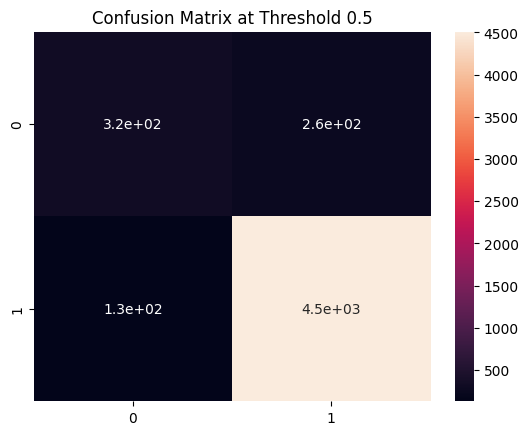

Zero-one loss at threshold 0.5: 0.0740


In [16]:
# predictions
dtest = xgb.DMatrix(X_test)
y_pred = clf.predict(dtest)

y_pred_bin = (y_pred > 0.5).astype(int)

# best threshold
threshold = 0.5

# classification report
accuracy = accuracy_score(y_test, y_pred_bin)
print(f"Accuracy: {accuracy:.4f}")  
print(classification_report(y_test, y_pred_bin, target_names=["<300nM", ">300nM"]))

# confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cf_matrix, annot=True)
plt.title(f"Confusion Matrix at Threshold {threshold:.1f}")
plt.show()

# zero-one loss
zero_one_loss = (y_pred_bin != y_test).mean()
print(f"Zero-one loss at threshold {threshold:.1f}: {zero_one_loss:.4f}")

# thresholds = np.arange(0.1, 1.0, 0.1)

# # iterate over thresholds
# for threshold in thresholds:
#     y_pred_bin = (y_pred > threshold).astype(int)
    
#     # accuracy
#     accuracy = accuracy_score(y_test, y_pred_bin)
#     print(f"Threshold: {threshold:.1f}, Accuracy: {accuracy:.4f}")
    
#     # classification report
#     print(classification_report(y_test, y_pred_bin, target_names=["<300nM", ">300nM"]))
    
#     # confusion matrix
#     cf_matrix = confusion_matrix(y_test, y_pred_bin)
#     sns.heatmap(cf_matrix, annot=True)
#     plt.title(f"Confusion Matrix at Threshold {threshold:.1f}")
#     plt.show()
    
#     # zero-one loss
#     zero_one_loss = (y_pred_bin != y_test).mean()
#     print(f"Zero-one loss at threshold {threshold:.1f}: {zero_one_loss:.4f}")

In [17]:
def label_to_category(label):
  if label == 0:
      return "<300nM"
  else:
      return ">300nM"

predicted_categories = [label_to_category(label) for label in y_pred]

results_df = pd.DataFrame({
    'Kinase': binding_data['Kinase'].iloc[indices_test].values,
    'Compound': binding_data['Compound'].iloc[indices_test].values,
    'Predicted_Kd_Category': predicted_categories
})

results_df.to_csv('300_kd_category.csv', index=False)

## Categorization for KD 3000

In [18]:
def categorize_kd_3000(kd):
  if kd < 3000:
      return 0 # strong binding
  else:
      return 1 # weak binding

binding_data['Kd_category'] = binding_data['Kd'].apply(categorize_kd_3000)
print(binding_data.head())

  Accession Number Entrez Gene Symbol                         Kinase  \
0      NP_055726.3               AAK1                           AAK1   
1      NP_005148.2               ABL1     ABL1(E255K)-phosphorylated   
2      NP_005148.2               ABL1  ABL1(F317I)-nonphosphorylated   
3      NP_005148.2               ABL1     ABL1(F317I)-phosphorylated   
4      NP_005148.2               ABL1  ABL1(F317L)-nonphosphorylated   

   Compound       Kd          0          1          2          3          4  \
0  A-674563     43.0  -0.813679 -29.187014  13.221566  21.716599  21.009573   
1  A-674563  10001.0  12.826459  43.214863  13.407912  21.331444  44.701019   
2  A-674563  10001.0  13.478254  42.953426  13.528316  21.925327  44.929493   
3  A-674563  10001.0  13.478270  42.953411  13.528316  21.925386  44.929520   
4  A-674563  10001.0  12.943295  42.563278  13.421924  22.069048  45.136337   

   ...       129       130       131       132  \
0  ...  1.279432 -0.871560 -1.349188  4.98

In [19]:
# TRAINING CLASSIFICATION

# extract features
fingerprints = np.array(binding_data['Fingerprint'].tolist())
embeddings = np.array(binding_data[[i for i in range(133)]])
# mutant = np.array(binding_data['Mutant']).reshape(-1, 1)
# kinase_group = binding_data[kinase_group_df.columns].values
binding_mode = binding_data[binding_mode_df.columns].values

X = np.hstack((fingerprints, embeddings, binding_mode))
y = binding_data['Kd_category'].values

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, range(len(X)), test_size=0.2, stratify=y, random_state=42
)

# # class weighting
# counter = Counter(y_train)
# majority_class = max(counter, key=counter.get)
# class_weights = {cls: counter[majority_class] / count for cls, count in counter.items()}

# positive_count = counter[1]
# negative_count = counter[0]
# print(positive_count, negative_count)
# scale_pos_weight = negative_count / positive_count
# print(scale_pos_weight)

#convert to matrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# params
# params = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',
#     'scale_pos_weight': scale_pos_weight,
#     'max_depth': 3,
#     'eta': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
# }
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

# SMOTE AGAIN???
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

dtrain_resampled = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)

def f1_score_eval(preds, dtrain):
    labels = dtrain.get_label()
    preds = (preds > 0.5).astype(int)
    tp = np.sum((preds == 1) & (labels == 1))
    fp = np.sum((preds == 1) & (labels == 0))
    fn = np.sum((preds == 0) & (labels == 1))
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return 'f1_score', f1

evals = [(dtrain, 'train'), (dtest, 'test')]
#clf = xgb.train(params, dtrain, num_boost_round=400, evals=evals, feval=f1_score_eval)
# clf = xgb.train(params, dtrain, num_boost_round=600)
clf = xgb.train(params, dtrain_resampled, num_boost_round=600)

(26078, 2184)
(26078,)


Accuracy: 0.8629
              precision    recall  f1-score   support

      <300nM       0.75      0.62      0.68      1221
      >300nM       0.89      0.94      0.91      3995

    accuracy                           0.86      5216
   macro avg       0.82      0.78      0.80      5216
weighted avg       0.86      0.86      0.86      5216



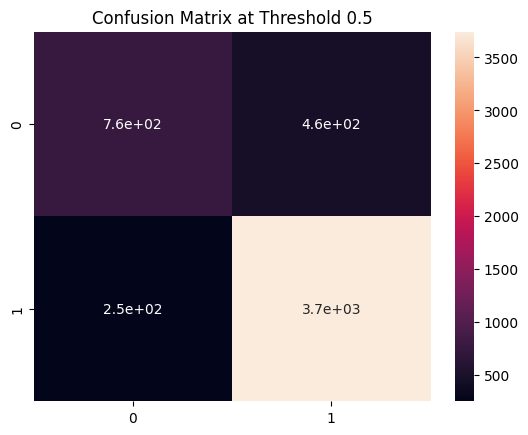

Zero-one loss at threshold 0.5: 0.1371


In [20]:
# predictions
dtest = xgb.DMatrix(X_test)
y_pred = clf.predict(dtest)

y_pred_bin = (y_pred > 0.5).astype(int)

# best threshold
threshold = 0.5

# classification report
accuracy = accuracy_score(y_test, y_pred_bin)
print(f"Accuracy: {accuracy:.4f}")  
print(classification_report(y_test, y_pred_bin, target_names=["<300nM", ">300nM"]))

# confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cf_matrix, annot=True)
plt.title(f"Confusion Matrix at Threshold {threshold:.1f}")
plt.show()

# zero-one loss
zero_one_loss = (y_pred_bin != y_test).mean()
print(f"Zero-one loss at threshold {threshold:.1f}: {zero_one_loss:.4f}")

# thresholds = np.arange(0.1, 1.0, 0.1)

# # iterate over thresholds
# for threshold in thresholds:
#     y_pred_bin = (y_pred > threshold).astype(int)
    
#     # accuracy
#     accuracy = accuracy_score(y_test, y_pred_bin)
#     print(f"Threshold: {threshold:.1f}, Accuracy: {accuracy:.4f}")
    
#     # classification report
#     print(classification_report(y_test, y_pred_bin, target_names=["<3000nM", ">3000nM"]))
    
#     # confusion matrix
#     cf_matrix = confusion_matrix(y_test, y_pred_bin)
#     sns.heatmap(cf_matrix, annot=True)
#     plt.title(f"Confusion Matrix at Threshold {threshold:.1f}")
#     plt.show()
    
#     # zero-one loss
#     zero_one_loss = (y_pred_bin != y_test).mean()
#     print(f"Zero-one loss at threshold {threshold:.1f}: {zero_one_loss:.4f}")

In [21]:
def label_to_category(label):
  if label == 0:
      return "<3000nM"
  else:
      return ">3000nM"

predicted_categories = [label_to_category(label) for label in y_pred]

results_df = pd.DataFrame({
    'Kinase': binding_data['Kinase'].iloc[indices_test].values,
    'Compound': binding_data['Compound'].iloc[indices_test].values,
    'Predicted_Kd_Category': predicted_categories
})

results_df.to_csv('3000_kd_category.csv', index=False)

## FAILED REGRESSION TASKS

In [22]:
# TRAINING REGRESSION

# labelling
label_encoder_kinase = LabelEncoder()
label_encoder_compound = LabelEncoder()

binding_data['Kinase_encoded'] = label_encoder_kinase.fit_transform(binding_data['Kinase'])
binding_data['Compound_encoded'] = label_encoder_compound.fit_transform(binding_data['Compound'])

# convert 'Embedding' and 'Fingerprint' columns to lists (if they're not already)
binding_data['Embedding'] = binding_data['Embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x))
binding_data['Fingerprint'] = binding_data['Fingerprint'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x))

def combine_features(row):
    return np.concatenate([row['Embedding'], row['Fingerprint'], [row['Kinase_encoded']], [row['Compound_encoded']]])
binding_data['features'] = binding_data.apply(combine_features, axis=1)
X = np.array(binding_data['features'].tolist())  # Feature matrix
y = binding_data['Kd'].values  # Target variable

print(X.shape)
print(y.shape)


(26078, 2183)
(26078,)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Mean Absolute Error: 1872.671648759877
Root Mean Squared Error: 2673.200958497591
R² Score: 0.5478562884837219


## With SMOTE

In [24]:
# TRAINING CLASSIFICATION

fingerprints = np.array(binding_data['Fingerprint'].tolist())

embeddings = np.array(binding_data[[i for i in range(133)]])

X = np.hstack((fingerprints, embeddings))
y = binding_data['Kd_category'].values

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smt = SMOTETomek(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)

clf = XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss")

clf.fit(X_train, y_train)


(26078, 2181)
(26078,)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3, ...)

In [25]:
# Predictions
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

## notes lol
# - some sort of weight tensor
# - error calculation

# Detailed classification report
print(classification_report(y_test, y_pred, target_names=["<300nM", "<3000nM", ">3000nM"]))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)


Accuracy: 0.8742


ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter